# Regression: XGBoost and Neural Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('data/final.csv')
boolean_columns = df.select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)
city_columns = [col for col in df.columns if col.startswith('city_')]
df['city_label'] = df[city_columns].idxmax(axis=1).str.replace('city_', '')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587516 entries, 0 to 587515
Data columns (total 65 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   host_since                                    587516 non-null  float64
 1   host_response_rate                            587516 non-null  float64
 2   host_acceptance_rate                          587516 non-null  float64
 3   host_is_superhost                             587516 non-null  int64  
 4   host_listings_count                           587516 non-null  float64
 5   host_total_listings_count                     587516 non-null  float64
 6   host_has_profile_pic                          587516 non-null  int64  
 7   host_identity_verified                        587516 non-null  int64  
 8   neighbourhood_cleansed                        587516 non-null  int64  
 9   latitude                                      58

In [3]:
df.describe()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,city_Athens,city_Berlin,city_Madrid,city_Paris,city_Rome,city_Vienna
count,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,...,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000,587516.000000
mean,84.484593,76.692946,74.984618,0.263920,32.075703,42.490210,0.962578,0.949649,9.725279,45.470107,...,0.829877,0.008335,0.155203,0.006585,0.086707,0.045267,0.144864,0.454171,0.192434,0.076556
std,44.214732,40.006813,37.228293,0.440757,111.145935,162.764145,0.189794,0.218668,7.537949,4.366768,...,0.375741,0.090916,0.362098,0.080883,0.281406,0.207889,0.351964,0.497896,0.394212,0.265886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,37.950322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.500000,80.000000,62.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,41.864983,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,92.500000,100.000000,98.000000,0.000000,2.000000,3.000000,1.000000,1.000000,8.000000,48.268639,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,119.666667,100.000000,100.000000,1.000000,11.000000,14.000000,1.000000,1.000000,16.000000,48.867580,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,199.433333,100.000000,100.000000,1.000000,7397.000000,9520.000000,1.000000,1.000000,45.000000,52.652280,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
X = df.drop(columns=['price', 'city_label'])  # Features
y = df['price']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['city_label'],
                                                    shuffle=True)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (470012, 63)
X_test shape: (117504, 63)
y_train shape: (470012,)
y_test shape: (117504,)


# XGBoost regression starts here (no need for feature scaling)

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import numpy as np

In [6]:
train_data = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns))
test_data = xgb.DMatrix(X_test, label=y_test, feature_names=list(X.columns))

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.2,
    "max_depth": 7,
    "gamma": 0,
    "tree_method": "hist",
    "device": "cuda",
    "eval_metric": "rmse"
}
evals_result = {}
evals = [(train_data, "train"), (test_data, "validation")]
model = xgb.train(dtrain=train_data, evals=evals, params=params, num_boost_round=3000, early_stopping_rounds=10, evals_result=evals_result)
# model.fit(train_data)
# pred = model.predict(test_data)
#
# rsme = root_mean_squared_error(y_test, pred)
# mse = mean_squared_error(y_test, pred)
# r2 = r2_score(y_test, pred)
# print("RSME:", rsme)
# print("MSE:", mse)
# print("R2:", r2)


[0]	train-rmse:0.70224	validation-rmse:0.69780
[1]	train-rmse:0.64597	validation-rmse:0.64202
[2]	train-rmse:0.60444	validation-rmse:0.60115
[3]	train-rmse:0.57426	validation-rmse:0.57151
[4]	train-rmse:0.55103	validation-rmse:0.54859
[5]	train-rmse:0.53363	validation-rmse:0.53171
[6]	train-rmse:0.51979	validation-rmse:0.51808
[7]	train-rmse:0.50808	validation-rmse:0.50658
[8]	train-rmse:0.49896	validation-rmse:0.49781
[9]	train-rmse:0.49139	validation-rmse:0.49063
[10]	train-rmse:0.48517	validation-rmse:0.48469
[11]	train-rmse:0.47982	validation-rmse:0.47972
[12]	train-rmse:0.47420	validation-rmse:0.47470
[13]	train-rmse:0.46976	validation-rmse:0.47058
[14]	train-rmse:0.46625	validation-rmse:0.46733
[15]	train-rmse:0.46192	validation-rmse:0.46326
[16]	train-rmse:0.45796	validation-rmse:0.45941
[17]	train-rmse:0.45558	validation-rmse:0.45720
[18]	train-rmse:0.45312	validation-rmse:0.45491
[19]	train-rmse:0.45061	validation-rmse:0.45263
[20]	train-rmse:0.44827	validation-rmse:0.45041
[2

In [7]:
pred_train = model.predict(train_data)
rsme_train = root_mean_squared_error(y_train, pred_train)
mse_train = mean_squared_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
print("Training data metrics")
print("RSME: ", rsme_train)
print("MSE: ", mse_train)
print("R2: ", r2_train)

pred_test = model.predict(test_data)
rsme_test = root_mean_squared_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
print("Testing data metrics")
print("RSME: ", rsme_test)
print("MSE: ", mse_test)
print("R2: ", r2_test)

Training data metrics
RSME:  0.17157323957383297
MSE:  0.02943737653785988
R2:  0.951595205627464
Testing data metrics
RSME:  0.32822388406993186
MSE:  0.10773091807395206
R2:  0.8206355422745089


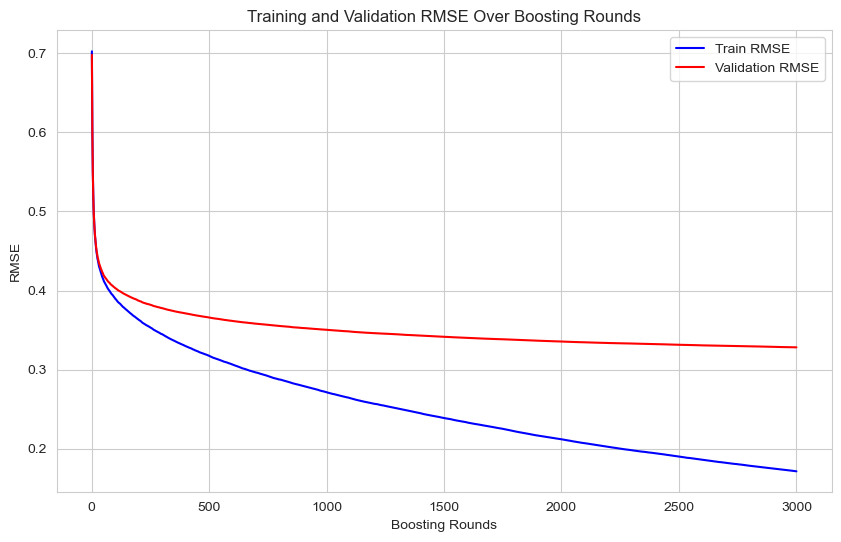

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
train_rmse = evals_result['train']['rmse']
validation_rmse = evals_result['validation']['rmse']

# Convert to a pandas DataFrame for easier plotting
rsme_df = pd.DataFrame({
    'Boosting Round': np.arange(1, len(train_rmse) + 1),
    'Train RMSE': train_rmse,
    'Validation RMSE': validation_rmse
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=rsme_df, x='Boosting Round', y='Train RMSE', label='Train RMSE', color='blue')
sns.lineplot(data=rsme_df, x='Boosting Round', y='Validation RMSE', label='Validation RMSE', color='red')

# Customize the plot
plt.title("Training and Validation RMSE Over Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

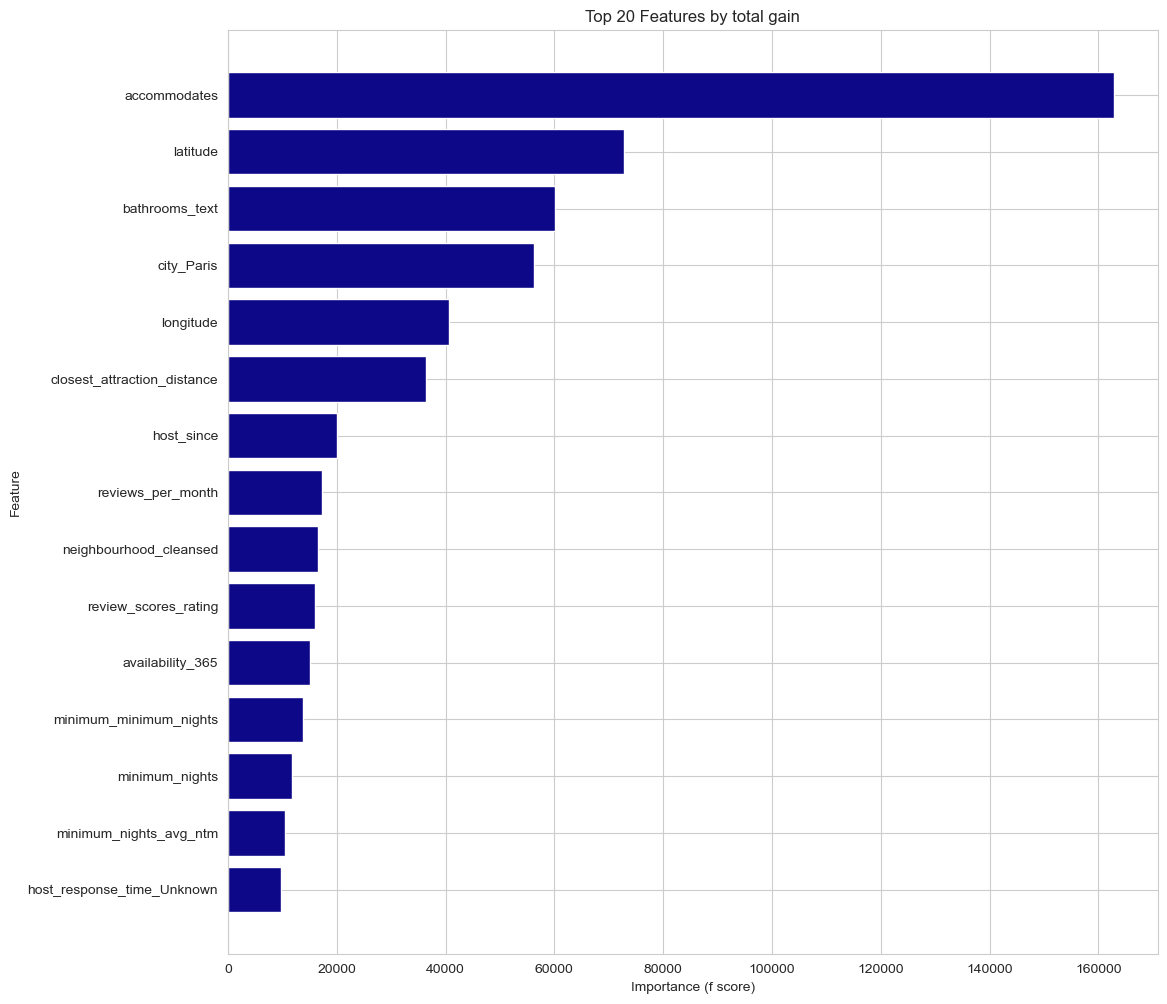

In [9]:
importance = model.get_score(importance_type='total_gain')

# Print or sort feature importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
sorted_importance = sorted_importance[:15]

# Optionally, plot it
import matplotlib.pyplot as plt
import matplotlib.cm as cm

features = [item[0] for item in sorted_importance]
importances = [item[1] for item in sorted_importance]

# Normalize importance values to use with a colormap
norm = plt.Normalize(vmin=min(importances), vmax=max(importances))
cmap = cm.plasma_r  # You can change this to another colormap like 'plasma', 'inferno', etc.

# Generate colors based on normalized importance values
colors = [cmap(value) for value in importances]
plt.figure(figsize=(12, 12))

# Bar plot with colors from the colormap
bars = plt.barh(features[::-1], importances[::-1], color=colors)
# plt.barh(keys, values)
plt.xlabel('Importance (f score)')
plt.ylabel('Feature')
plt.title('Top 20 Features by total gain')
plt.show()

In [10]:
import shap
import warnings
warnings.filterwarnings('ignore')
total = X_train + X_test
print("shape: ", total.shape)

C:\Users\Mahak\anaconda3\envs\code\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


shape:  (587516, 63)


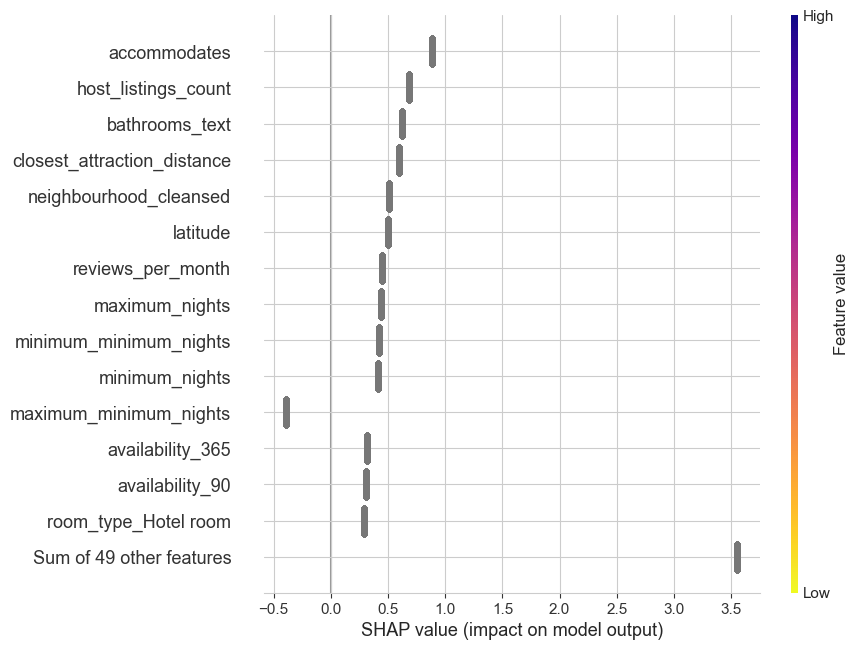

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(total)


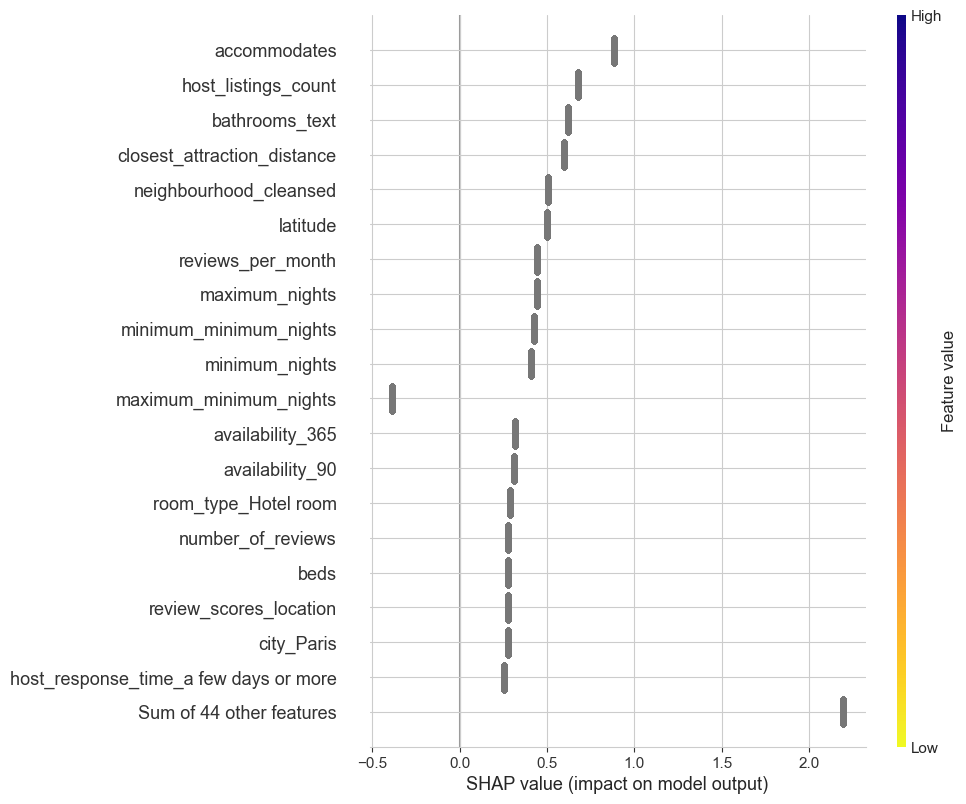

In [14]:
shap.plots.beeswarm(shap_values, max_display=20, color=plt.get_cmap("plasma_r"))